# 作业一：实现HMM中文分词和BPE英文分词
姓名：陶瑞
学号：522030910024

## 任务一：HMM模型用于中文分词

任务一评分标准：
1. 共有8处TODO需要填写，每个TODO计1-2分，共9分，预计代码量30行；
2. 允许自行修改、编写代码完成，对于该情况，请补充注释以便于评分，否则结果不正确将导致较多的扣分；
3. 用于说明实验的文字和总结不额外计分，但不写会导致扣分。

注：本任务仅在短句子上进行效果测试，因此对概率的计算可直接进行连乘。在实践中，常先对概率取对数，将连乘变为加法来计算，以避免出现数值溢出的情况。

导入HMM参数，初始化所需的起始概率矩阵，转移概率矩阵，发射概率矩阵

In [2]:
import pickle
import numpy as np

In [3]:
with open("hmm_parameters.pkl", "rb") as f:
    hmm_parameters = pickle.load(f)

# 非断字（B）为第0行，断字（I）为第1行
# 发射概率矩阵中，词典大小为65536，以汉字的ord作为行key
start_probability = hmm_parameters["start_prob"]  # shape(2,)
trans_matrix = hmm_parameters["trans_mat"]  # shape(2, 2)
emission_matrix = hmm_parameters["emission_mat"]  # shape(2, 65536)
print("start_prob shape:", start_probability.shape)
print("trans_mat:", trans_matrix)
print("emission_mat shape:", emission_matrix.shape)

start_prob shape: (2,)
trans_mat: [[0.18967134 0.81032866]
 [0.4821748  0.5178252 ]]
emission_mat shape: (2, 65536)


定义待处理的句子

In [4]:
# TODO: 将input_sentence中的xxx替换为你的姓名（1分）
input_sentence = "陶瑞是一名优秀的学生"
# input_sentence = "学生是一名优秀的学生"
# input_sentence = "我有个做中文分词的方法"
# input_sentence = "我有一个实现中文分词的方法"
# input_sentence = "你吃饭了吗"

实现viterbi算法，并以此进行中文分词

（算法的具体细节在注释中给出）

In [5]:
def viterbi(sent_orig, start_prob, trans_mat, emission_mat):
    """
    viterbi算法进行中文分词

    Args:
        sent_orig: str - 输入的句子
        start_prob: numpy.ndarray - 起始概率矩阵
        trans_mat: numpy.ndarray - 转移概率矩阵
        emission_mat: numpy.ndarray - 发射概率矩阵

    Return:
        str - 中文分词的结果
    """

    #  将汉字转为数字表示
    sent_ord = [ord(x) for x in sent_orig]

    # `dp`用来储存不同位置每种标注（B/I）的最大概率值
    dp = np.zeros((2, len(sent_ord)), dtype=float)

    # `path`用来储存最大概率对应的上步B/I选择
    #  例如 path[1][7] == 1 意味着第8个（从1开始计数）字符标注I对应的最大概率，其前一步的隐状态为1（I）
    #  例如 path[0][5] == 1 意味着第6个字符标注B对应的最大概率，其前一步的隐状态为1（I）
    #  例如 path[1][1] == 0 意味着第2个字符标注I对应的最大概率，其前一步的隐状态为0（B）
    path = np.zeros((2, len(sent_ord)), dtype=int)

    #  TODO: 第一个位置的最大概率值计算（1分）
    # 第一个位置的计算是 P(BI, x1) = P(BI) * P(x1|BI)
    # 其中 P(BI) 由起始矩阵得到, P(x1|BI) 由发射矩阵得到
    # 在分词任务中, BI 只有2种可能, 所以下面所有过程都是循环两遍
    for i in range(2):
        dp[i][0] = start_prob[i] * emission_mat[i][sent_ord[0]]

    #  TODO: 其余位置的最大概率值计算（填充dp和path矩阵）（2分）
    # 最外层的循环针对每个位置
    for i in range(1, len(sent_ord)):
        # 每个位置上遍历隐状态, 求每个位置不同 BI 情况下各自的概率
        for j in range(2):
            max_value = -1
            max_path = None
            # 实际可以不写这个循环, 相当于就是求 max_{可能转移过来的状态}
            # 循环可以更方便找到对应的最大值是从哪里转移过来的, 方便记录 path
            for left_tag in range(2):
                # 转移: P(left) * P(xi | left_tag) * P(BI | xi)
                # 在这里 P(left) 表示上一个位置从 left_tag 转移过来, 因此就是 dp[left_tag][i-1]
                # 剩下两项都从输入读取的 转移矩阵和发射矩阵种读取
                tmp = dp[left_tag][i - 1] * trans_mat[left_tag][j] * emission_mat[j][sent_ord[i]]
                # 更新最大值 和 取到最大值时是从哪个 tag 转移过来的
                if tmp > max_value:
                    max_value = tmp
                    max_path = left_tag
            # 取遍 BI 后最终更新 dp 和 path
            dp[j][i] = max_value
            path[j][i] = max_path

    #  `labels`用来储存每个位置最有可能的隐状态
    labels = [0 for _ in range(len(sent_ord))]

    #  TODO: 计算labels每个位置上的值（填充labels矩阵）（1分）
    # 最后一位的标注是最后一个位置的最大概率值对应的标注
    labels[-1] = np.argmax(dp[:, -1])
    for i in range(len(sent_ord) - 2, -1, -1):
        # 第 i 位的标注看 path 中记录的 i+1 位更新最大值时, 是从哪个上一位转移过来的
        # 也就是第 i 位最优的标注
        labels[i] = path[labels[i + 1]][i + 1]

    #  根据lalels生成切分好的字符串
    sent_split = []
    for idx, label in enumerate(labels):
        if label == 1:
            sent_split += [sent_ord[idx], ord("/")]
        else:
            sent_split += [sent_ord[idx]]
    sent_split_str = "".join([chr(x) for x in sent_split])

    return sent_split_str

In [6]:
print("viterbi算法分词结果:", viterbi(input_sentence, start_probability, trans_matrix, emission_matrix))

viterbi算法分词结果: 陶瑞是/一名/优秀/的/学生/


实现前向算法，计算该句子的概率值

（从算法实现上来说，前向算法和Viterbi几乎完全一样，只是把 $\max$ 项变成求和）

（因此我算法的注释也基本照抄了Viterbi算法的注释）

In [7]:
def compute_prob_by_forward(sent_orig, start_prob, trans_mat, emission_mat):
    """
    前向算法，计算输入中文句子的概率值

    Args:
        sent_orig: str - 输入的句子
        start_prob: numpy.ndarray - 起始概率矩阵
        trans_mat: numpy.ndarray - 转移概率矩阵
        emission_mat: numpy.ndarray - 发射概率矩阵

    Return:
        float - 概率值
    """

    #  将汉字转为数字表示
    sent_ord = [ord(x) for x in sent_orig]

    # `dp`用来储存不同位置每种隐状态（B/I）下，到该位置为止的句子的概率
    dp = np.zeros((2, len(sent_ord)), dtype=float)

    # TODO: 初始位置概率的计算（1分）
    # 第一个位置的计算是 P(BI, x1) = P(BI) * P(x1|BI)
    # 其中 P(BI) 由起始矩阵得到, P(x1|BI) 由发射矩阵得到
    for i in range(2):
        dp[i][0] = start_prob[i] * emission_mat[i][sent_ord[0]]
    # TODO: 先计算其余位置的概率（填充dp矩阵），然后return概率值（1分）
    # 最外层的循环针对每个位置 (每个词)
    for i in range(1, len(sent_ord)):
        # 每个位置上遍历隐状态, 求截止到这个位置不同 BI 情况下各自的概率
        for j in range(2):
            # 对于 dp[j][i] 这个位置, 对所有能转移到它这里的状态求和
            dp[j][i] = sum([
                dp[left_tag][i - 1] * trans_mat[left_tag][j] * emission_mat[j][sent_ord[i]]
                 for left_tag in range(2)
            ])

    return sum([dp[i][len(sent_ord) - 1] for i in range(2)])

实现后向算法，计算该句子的概率值

（算法的具体细节在注释中给出）

In [8]:
def compute_prob_by_backward(sent_orig, start_prob, trans_mat, emission_mat):
    """
    后向算法，计算输入中文句子的概率值

    Args:
        sent_orig: str - 输入的句子
        start_prob: numpy.ndarray - 起始概率矩阵
        trans_mat: numpy.ndarray - 转移概率矩阵
        emission_mat: numpy.ndarray - 发射概率矩阵

    Return:
        float - 概率值
    """

    #  将汉字转为数字表示
    sent_ord = [ord(x) for x in sent_orig]

    # `dp`用来储存不同位置每种隐状态（B/I）下，从结尾到该位置为止的句子的概率
    dp = np.zeros((2, len(sent_ord)), dtype=float)

    # TODO: 终末位置概率的初始化（1分）
    # 最后一位的概率为 1
    for i in range(2):
        dp[i][-1] = 1

    # TODO: 先计算其余位置的概率（填充dp矩阵），然后return概率值（1分）
    # 最外层的循环从后向前针对每个位置
    for i in range(len(sent_ord) - 2, -1, -1):
        # 每个位置上遍历隐状态, 求截止到这个位置不同 BI 情况下各自的概率
        for j in range(2):
            # 对于 dp[j][i] 这个位置, 对所有能从它转移出去的状态求和
            dp[j][i] = sum([
                dp[right_tag][i + 1] * trans_matrix[j][right_tag] * emission_matrix[right_tag][sent_ord[i + 1]]
                for right_tag in range(2)
            ])

    return sum([dp[i][0] * start_prob[i] * emission_mat[i][sent_ord[0]] for i in range(2)])

In [9]:
print("Input:", input_sentence)
print("前向算法概率：", compute_prob_by_forward(input_sentence, start_probability, trans_matrix, emission_matrix))
print("后向算法概率：", compute_prob_by_backward(input_sentence, start_probability, trans_matrix, emission_matrix))

Input: 陶瑞是一名优秀的学生
前向算法概率： 6.034564902506927e-30
后向算法概率： 6.034564902506927e-30


**TODO：实验总结**

更多的对 Viterbi、前向算法、后向算法的测试句子如下所示，Viterbi的分词效果并没有达到非常理想，表现为经常错误地分隔单个字。前向算法和后向算法计算的概率是相同的（除去数值精度影响），这与理论结果一致。

In [10]:
test_sentence_tuple = [
    ("你吃饭了吗", "吃饭了吗你"),
    ("小明是常见的名字", "隐马不是常见的名字"),
    ("最外层从后向前的循环针对每个位置", "最外层会针对每一个位置进行从后向前的循环")
]
for i, tup in enumerate(test_sentence_tuple):
    division1 = viterbi(tup[0], start_probability, trans_matrix, emission_matrix)
    division2 = viterbi(tup[1], start_probability, trans_matrix, emission_matrix)
    p1_f = compute_prob_by_forward(tup[0], start_probability, trans_matrix, emission_matrix)
    p2_f = compute_prob_by_forward(tup[1], start_probability, trans_matrix, emission_matrix)
    print("{} | {} | {}".format(i+1, division1, division2))
    print("  Forward |")
    print("   {} | {}".format(p1_f, tup[0]))
    print("   {} | {}".format(p2_f, tup[1]))
    # p1_b = compute_prob_by_backward(tup[0], start_probability, trans_matrix, emission_matrix)
    # p2_b = compute_prob_by_backward(tup[1], start_probability, trans_matrix, emission_matrix)
    # print("  Backward |")
    # print("   {} | {}".format(p1_b, tup[0]))
    # print("   {} | {}".format(p2_b, tup[1]))

1 | 你/吃/饭了/吗/ | 吃饭/了/吗/你/
  Forward |
   1.5411621241433865e-18 | 你吃饭了吗
   1.6437574917594602e-18 | 吃饭了吗你
2 | 小明/是/常/见/的/名字/ | 隐马/不是/常/见/的/名字/
  Forward |
   8.619496302661203e-23 | 小明是常见的名字
   8.367528454584874e-28 | 隐马不是常见的名字
3 | 最外/层/从/后/向/前/的/循/环针/对/每/个/位/置/ | 最外/层/会/针对/每/一个/位/置/进行/从/后/向/前/的/循/环
  Forward |
   1.3879345259233953e-51 | 最外层从后向前的循环针对每个位置
   8.710127920547368e-62 | 最外层会针对每一个位置进行从后向前的循环


## 任务二：BPE算法用于英文分词

任务二评分标准：

1. 共有7处TODO需要填写，每个TODO计1-2分，共9分，预计代码量50行；
2. 允许自行修改、编写代码完成，对于该情况，请补充注释以便于评分，否则结果不正确将导致较多的扣分；
3. 用于说明实验的文字和总结不额外计分，但不写会导致扣分。

构建空格分词器，将语料中的句子以空格切分成单词，然后将单词拆分成字母加`</w>`的形式。例如`apple`将变为`a p p l e </w>`。

In [11]:
import re
import functools

In [12]:
_splitor_pattern = re.compile(r"[^a-zA-Z']+|(?=')")
_digit_pattern = re.compile(r"\d+")


def white_space_tokenize(corpus):
    """
    先正则化（字母转小写、数字转为N、除去标点符号），然后以空格分词语料中的句子，例如：
    输入 corpus=["I am happy.", "I have 10 apples!"]，
    得到 [["i", "am", "happy"], ["i", "have", "N", "apples"]]

    Args:
        corpus: List[str] - 待处理的语料

    Return:
        List[List[str]] - 二维List，内部的List由每个句子的单词str构成
    """

    tokeneds = [list(filter(lambda tkn: len(tkn) > 0, _splitor_pattern.split(_digit_pattern.sub("N", stc.lower())))) for stc in corpus]

    return tokeneds

编写相应函数构建BPE算法需要用到的初始状态词典

In [13]:
def build_bpe_vocab(corpus):
    """
    将语料进行white_space_tokenize处理后，将单词每个字母以空格隔开、结尾加上</w>后，构建带频数的字典，例如：
    输入 corpus=["I am happy.", "I have 10 apples!"]，
    得到
    {
        'i </w>': 2,
        'a m </w>': 1,
        'h a p p y </w>': 1,
        'h a v e </w>': 1,
        'N </w>': 1,
        'a p p l e s </w>': 1
     }

    Args:
        corpus: List[str] - 待处理的语料

    Return:
        Dict[str, int] - "单词分词状态->频数"的词典
    """

    tokenized_corpus = white_space_tokenize(corpus)

    bpe_vocab = dict()

    # TODO: 完成函数体（1分）
    # 外层遍历句子列表, 内层遍历每句话中的每个单词
    for sentence in tokenized_corpus:
        for word in sentence:
            # 添加的 key 的形式是 先把原有单词按字母空格分开, 然后末尾加上 "</w>"
            # 添加末尾字符后, 检查是否在字典中存在, 不存在则添加, 存在则增加频数
            _w = ' '.join(list(word)) + " </w>"
            if _w not in bpe_vocab:
                bpe_vocab[_w] = 1
            else:
                bpe_vocab[_w] += 1

    return bpe_vocab

**单元测试 1 -- 单词频数**

测试输入为按单词分割好的句子们, 输出为单词级别的频数

In [14]:
test_sentences = ["A short sentence.",
                  "Long senteces and a short sentences and a long sentence.",
                ]
tokenized_senteces = white_space_tokenize(test_sentences)
print("Tokenized:")
for i, sent in enumerate(tokenized_senteces):
    print("{} | {}".format(i, sent))
print("Output:")
bpe_vocab = build_bpe_vocab(test_sentences)
print(bpe_vocab)

Tokenized:
0 | ['a', 'short', 'sentence']
1 | ['long', 'senteces', 'and', 'a', 'short', 'sentences', 'and', 'a', 'long', 'sentence']
Output:
{'a </w>': 3, 's h o r t </w>': 2, 's e n t e n c e </w>': 2, 'l o n g </w>': 2, 's e n t e c e s </w>': 1, 'a n d </w>': 2, 's e n t e n c e s </w>': 1}


编写所需的其他函数

将前面 `build_bpe_vocab` 划分的单词级别的字典, 转换成字母对级别的 (Bi-gram) 字典

In [15]:
def get_bigram_freq(bpe_vocab):
    """
    统计"单词分词状态->频数"的词典中，各bigram的频次（假设该词典中，各个unigram以空格间隔），例如：
    输入 bpe_vocab=
    {
        'i </w>': 2,
        'a m </w>': 1,
        'h a p p y </w>': 1,
        'h a v e </w>': 1,
        'N </w>': 1,
        'a p p l e s </w>': 1
    }
    得到
    {
        ('i', '</w>'): 2,
        ('a', 'm'): 1,
        ('m', '</w>'): 1,
        ('h', 'a'): 2,
        ('a', 'p'): 2,
        ('p', 'p'): 2,
        ('p', 'y'): 1,
        ('y', '</w>'): 1,
        ('a', 'v'): 1,
        ('v', 'e'): 1,
        ('e', '</w>'): 1,
        ('N', '</w>'): 1,
        ('p', 'l'): 1,
        ('l', 'e'): 1,
        ('e', 's'): 1,
        ('s', '</w>'): 1
    }

    Args:
        bpe_vocab: Dict[str, int] - "单词分词状态->频数"的词典

    Return:
        Dict[Tuple(str, str), int] - "bigram->频数"的词典
    """

    bigram_freq = dict()

    # TODO: 完成函数体（1分）
    # 辅助函数, 向字典内添加指定数量的元素 (包括新建的时候)
    def _add_into_dict(k, num):
        # print("Adding {}, {}".format(k, num))
        if k not in bigram_freq:
            bigram_freq[k] = num
        else:
            bigram_freq[k] += num
    
    # 遍历所有大
    for word, frequency in bpe_vocab.items():
        # 按空格分割单词, 最后一个字符也被分割出去, 计算的时候和倒数第二个合并在一起
        word = word.split()
        # 遍历每个单词的每个字符, 添加其和下一个字符组成的tuple
        for i in range(len(word) - 1):
            _add_into_dict((word[i], word[i + 1]), frequency)

    return bigram_freq

**单元测试 2 -- 字母对频数**

测试输入为单词级别的频数字典, 输出为字母对级别的频数字典

In [16]:
print("Input:")
print(bpe_vocab)
bigram_dict = get_bigram_freq(bpe_vocab)
print("Bigram dict:")
print(bigram_dict)

Input:
{'a </w>': 3, 's h o r t </w>': 2, 's e n t e n c e </w>': 2, 'l o n g </w>': 2, 's e n t e c e s </w>': 1, 'a n d </w>': 2, 's e n t e n c e s </w>': 1}
Bigram dict:
{('a', '</w>'): 3, ('s', 'h'): 2, ('h', 'o'): 2, ('o', 'r'): 2, ('r', 't'): 2, ('t', '</w>'): 2, ('s', 'e'): 4, ('e', 'n'): 7, ('n', 't'): 4, ('t', 'e'): 4, ('n', 'c'): 3, ('c', 'e'): 4, ('e', '</w>'): 2, ('l', 'o'): 2, ('o', 'n'): 2, ('n', 'g'): 2, ('g', '</w>'): 2, ('e', 'c'): 1, ('e', 's'): 2, ('s', '</w>'): 2, ('a', 'n'): 2, ('n', 'd'): 2, ('d', '</w>'): 2}


In [17]:
def refresh_bpe_vocab_by_merging_bigram(bigram, old_bpe_vocab):
    """
    在"单词分词状态->频数"的词典中，合并指定的bigram（即去掉对应的相邻unigram之间的空格），最后返回新的词典，例如：
    输入 bigram=('i', '</w>')，old_bpe_vocab=
    {
        'i </w>': 2,
        'a m </w>': 1,
        'h a p p y </w>': 1,
        'h a v e </w>': 1,
        'N </w>': 1,
        'a p p l e s </w>': 1
    }
    得到
    {
        'i</w>': 2,
        'a m </w>': 1,
        'h a p p y </w>': 1,
        'h a v e </w>': 1,
        'N </w>': 1,
        'a p p l e s </w>': 1
    }

    Args:
        old_bpe_vocab: Dict[str, int] - 初始"单词分词状态->频数"的词典

    Return:
        Dict[str, int] - 合并后的"单词分词状态->频数"的词典
    """

    new_bpe_vocab = dict()

    # TODO: 完成函数体（1分）
    # 遍历原字典找到所有包含 bigram 的结构
    for word, frequency in old_bpe_vocab.items():
        # 查找 bigram 要先用空格合并起来, 因为替换之前还有空格
        # 找到的话，把 用空格连接的字符 替换为不带空格的字符
        # 然后作为新的 key 加入新字典 (原有 frequency)
        search_str = ' '.join(bigram)
        if search_str in word:
            new_word = word.replace(' '.join(bigram), ''.join(bigram))
            new_bpe_vocab[new_word] = frequency
        else:
            new_bpe_vocab[word] = frequency

    return new_bpe_vocab

**单元测试 3 -- 合并字母**

在 `build_bpe_vocab` 将句子按照单词级别分割后, 使用 `refresh_bpe_vocab_by_merging_bigram` 来消除其中指定字母之间的空格

In [18]:
print("Word Level dict:")
print(bpe_vocab)
_merge_bigram = refresh_bpe_vocab_by_merging_bigram(('a', '</w>'), bpe_vocab)
_merge_bigram = refresh_bpe_vocab_by_merging_bigram(('e', 'n'), _merge_bigram)
_merge_bigram = refresh_bpe_vocab_by_merging_bigram(('s', 'en'), _merge_bigram)
print("Merged dict:")
print(_merge_bigram)

Word Level dict:
{'a </w>': 3, 's h o r t </w>': 2, 's e n t e n c e </w>': 2, 'l o n g </w>': 2, 's e n t e c e s </w>': 1, 'a n d </w>': 2, 's e n t e n c e s </w>': 1}
Merged dict:
{'a</w>': 3, 's h o r t </w>': 2, 'sen t en c e </w>': 2, 'l o n g </w>': 2, 'sen t e c e s </w>': 1, 'a n d </w>': 2, 'sen t en c e s </w>': 1}


In [19]:
def get_bpe_tokens(bpe_vocab):
    """
    根据"单词分词状态->频数"的词典，返回所得到的BPE分词列表，并将该列表按照分词长度降序排序返回，例如：
    输入 bpe_vocab=
    {
        'i</w>': 2,
        'a m </w>': 1,
        'ha pp y </w>': 1,
        'ha v e </w>': 1,
        'N </w>': 1,
        'a pp l e s </w>': 1
    }
    得到
    [
        ('i</w>', 2),
        ('ha', 2),
        ('pp', 2),
        ('a', 2),
        ('m', 1),
        ('</w>', 5),
        ('y', 1),
        ('v', 1),
        ('e', 2),
        ('N', 1),
        ('l', 1),
        ('s', 1)
     ]

    Args:
        bpe_vocab: Dict[str, int] - "单词分词状态->频数"的词典

    Return:
        List[Tuple(str, int)] - BPE分词和对应频数组成的List
    """

    # TODO: 完成函数体（2分）
    # 先用字典来计数 (因为字典 key 是哈希存储的 查找更快)
    count_dict = dict()
    # 遍历每个 key
    # 再遍历 key 中所有空格分隔的字符 (可能若干字母组成)
    for key, frequency in bpe_vocab.items():
        for token in key.split():
            if token not in count_dict:
                count_dict[token] = frequency
            else:
                count_dict[token] += frequency

    bpe_tokens = list(count_dict.items())
    return bpe_tokens

**单元测试 4 -- BPE分词列表**

输入一个（经过merge的）`bpe_vocab` 字典，按照其每个单词的分割方式，累加各部分merge字符的frequency

In [20]:
print("Merged dict:")
print(_merge_bigram)
bpe_tokens = get_bpe_tokens(_merge_bigram)
print("BPE tokens:")
print(bpe_tokens)

Merged dict:
{'a</w>': 3, 's h o r t </w>': 2, 'sen t en c e </w>': 2, 'l o n g </w>': 2, 'sen t e c e s </w>': 1, 'a n d </w>': 2, 'sen t en c e s </w>': 1}
BPE tokens:
[('a</w>', 3), ('s', 4), ('h', 2), ('o', 4), ('r', 2), ('t', 6), ('</w>', 10), ('sen', 4), ('en', 3), ('c', 4), ('e', 5), ('l', 2), ('n', 4), ('g', 2), ('a', 2), ('d', 2)]


In [21]:
def print_bpe_tokenize(word, bpe_tokens):
    """
    根据按长度降序的BPE分词列表，将所给单词进行BPE分词，最后打印结果。
    
    思想是，对于一个待BPE分词的单词，按照长度顺序从列表中寻找BPE分词进行子串匹配，
    若成功匹配，则对该子串左右的剩余部分递归地进行下一轮匹配，直到剩余部分长度为0，
    或者剩余部分无法匹配（该部分整体由"<unknown>"代替）
    
    例1：
    输入 word="supermarket", bpe_tokens=[
        ("su", 20),
        ("are", 10),
        ("per", 30),
    ]
    最终打印 "su per <unknown>"

    例2：
    输入 word="shanghai", bpe_tokens=[
        ("hai", 1),
        ("sh", 1),
        ("an", 1),
        ("</w>", 1),
        ("g", 1)
    ]
    最终打印 "sh an g hai </w>"

    Args:
        word: str - 待分词的单词str
        bpe_tokens: List[Tuple(str, int)] - BPE分词和对应频数组成的List
    """

    # 将已有的BPEtoken按照从长到短的顺序排序
    # 则后面的匹配中只要按顺序遍历, 就能实现最长匹配
    sorted_bpe_tokens = sorted(bpe_tokens, key=lambda x: len(x[0]), reverse=True)
    assert len(sorted_bpe_tokens[0]) >= len(sorted_bpe_tokens[-1]), "BPE length order reversed..."

    # TODO: 请尝试使用递归函数定义该分词过程（2分）
    def bpe_tokenize(sub_word):
        if len(sub_word) == 0:
            return ""
        for token, freq in sorted_bpe_tokens:
            if sub_word.startswith(token):
                # 由于已经排过序, 只要先找到 sub_word 开头的字符串就是最长匹配
                # 则直接把 sub_word 从这里截断, 递归匹配后面
                return token + " " + bpe_tokenize(sub_word[len(token):])  
        # 运行到这里说明遍历已有的 BPE token 都没匹配
        return "<unknown>"

    res = bpe_tokenize(word + "</w>")
    print(res)

**单元测试 5 -- 按BPE列表分词**

按照已有的 BPE 分词列表，并按照最长匹配的规则，将一个输入句子用已有的分词进行分词，没有匹配的规则返回 `<unknown>`

In [22]:
print("BPE tokens:")
print(bpe_tokens)
test_sentences = [
    "sentehenfffen",
    "senensenena"
]
for sentence in test_sentences:
    print("Input:\t", sentence)
    print("Output:\t", end=' ')
    res = print_bpe_tokenize(sentence, bpe_tokens)

BPE tokens:
[('a</w>', 3), ('s', 4), ('h', 2), ('o', 4), ('r', 2), ('t', 6), ('</w>', 10), ('sen', 4), ('en', 3), ('c', 4), ('e', 5), ('l', 2), ('n', 4), ('g', 2), ('a', 2), ('d', 2)]
Input:	 sentehenfffen
Output:	 sen t e h en <unknown>
Input:	 senensenena
Output:	 sen en sen en a</w> 


开始读取数据集并训练BPE分词器

In [23]:
with open("data/news.2007.en.shuffled.deduped.train", encoding="utf-8") as f:
    training_corpus = list(map(lambda l: l.strip(), f.readlines()[:1000]))

print("Loaded training corpus.")

Loaded training corpus.


In [24]:
# 这个代码块中的函数用来辅助画图
import matplotlib.pyplot as plt

def draw_iters(results):
    fig, ax1 = plt.subplots()
    c1 = 'royalblue'
    c2 = 'maroon'

    dict_lens = results['lens']
    ax1.plot(dict_lens, c1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Remain Can be Merged', color=c1)
    ax1.tick_params('y', colors=c1)
    # ax1.set_ylim(1.05*max(dict_lens), 0.95*min(dict_lens))

    merge_freq = results['frequency']
    ax2 = ax1.twinx()
    ax2.plot(merge_freq, c2)
    ax2.set_ylabel('Merging Frequency', color=c2)
    ax2.tick_params('y', colors=c2)

    fig.tight_layout()
    # plt.savefig("./{}.png".format(len(dict_lens)))
    plt.show()

Train 500 iters (Adopted Version):


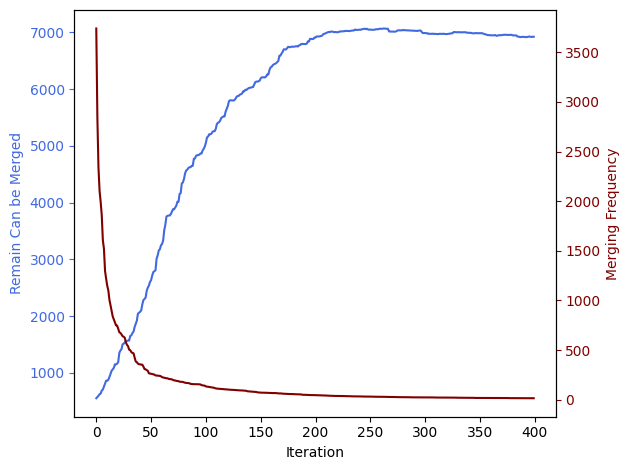

In [38]:
training_iter_num = 5000    # 这是为了画图而训练了很长5000轮, 实际最终使用下面的 adopt_iter_num 轮

training_bpe_vocab = build_bpe_vocab(training_corpus)

# 用于记录结果和画图
# 我是想看随着迭代的进行, 新产生的待合并字符对数量, 和被选择合并的字符对的频率
results = {
    'lens': [],
    'frequency': []
}

adopt_iter_num = 500    # 最终采用这个训练轮数
final_adopt_version = None  # 在到达这个轮数后, 把最终用来预测的结果存在这里

for i in range(training_iter_num):
    # TODO: 完成训练循环内的代码逻辑（2分）
    # 每轮循环先根据 当前的划分和合并 更新bigram 的频率
    bigram_frequency = get_bigram_freq(training_bpe_vocab)
    # 当训练轮数足够多时, 没有可以再合并的
    if len(bigram_frequency) == 0:
        print("No bigram to merge.")
        break
    if i == adopt_iter_num:
        # 达到想要的 adopt_iter_num 轮后, 保存结果, 剩下的训练只是为了画图
        final_adopt_version = training_bpe_vocab.copy()
    # 然后在一轮更新中, 找频率最高的 bigram 对合并
    max_bi_word, max_freq = max(bigram_frequency.items(), key=lambda item: item[1])
    training_bpe_vocab = refresh_bpe_vocab_by_merging_bigram(max_bi_word, training_bpe_vocab)

    # 记录待合并的字符对数量, 以及合并的字符对频率
    results['lens'].append(len(bigram_frequency))
    results['frequency'].append(max_freq)

# training_bpe_tokens = get_bpe_tokens(training_bpe_vocab)
training_bpe_tokens = get_bpe_tokens(final_adopt_version)
print("Train {} iters (Adopted Version):".format(adopt_iter_num))
draw_iters({k: v[:400] for k, v in results.items()})

测试BPE分词器的分词效果

In [39]:
test_word = "naturallanguageprocessing"

print("训练轮数:", adopt_iter_num)
print("naturallanguageprocessing 的分词结果为：")
print_bpe_tokenize(test_word, training_bpe_tokens)

训练轮数: 500
naturallanguageprocessing 的分词结果为：
n atur al lan gu age proce ssing</w> 


**TODO：实验总结**

1. 更新轮数对分词结果的影响

    在此测试了不同训练循环次数对分词结果的影响，如下表所示。可以看到，开始阶段，随着训练轮数的增加，分词结果从零散的单词字母，逐渐开始合并到有意义的词块。但随着训练轮数的进一步增加，出现了 “之前已经合并好的词块又被拆分开” 的情况，分词结果又开始有零散化的趋势。随着训练轮数继续增加，直到该训练数据上所能达到的最多可合并的轮数（约5500轮）时，分词结果已经几乎呈现和最开始少量训练一样的情况，最后训练到接近没有可合并的状态，分词功能已经几乎无法实现，甚至出现 `<unknown>` 。原因将在下一节分析，总之就是只有适中的训练轮数才能有较好的分词结果，过长或过短的训练都不行。

    | 更新轮数 | 分词结果 |
    | :-: | :-: |
    | 100 | <span style="font-family: Consolas; font-weight: bold;">n at u r al l an g u ag e pro c e s sing&lt;/w&gt;</span> |
    | 200 | <span style="font-family: Consolas; font-weight: bold;">n at ur al l an gu age pro c e s sing&lt;/w&gt;</span> |
    | 300 | <span style="font-family: Consolas; font-weight: bold;">n atur al lan gu age pro ce s sing&lt;/w&gt;</span> |
    | 400 | <span style="font-family: Consolas; font-weight: bold; color: green;">n atur al lan gu age pro ce ssing&lt;/w&gt;</span> |
    | 500 | <span style="font-family: Consolas; font-weight: bold; color: green;">n atur al lan gu age proce ssing&lt;/w&gt;</span>  |
    | 600 | <span style="font-family: Consolas; font-weight: bold; color: green;">n atur al lan gu age proce ssing&lt;/w&gt;</span> |
    | 700 | <span style="font-family: Consolas; font-weight: bold;">n atur al lan gu age proce ssi n g&lt;/w&gt;</span> |
    | 800 | <span style="font-family: Consolas; font-weight: bold;">n atur al lan gu age proce ssi n g&lt;/w&gt;</span> |
    | 900 | <span style="font-family: Consolas; font-weight: bold;">n atur al lan gu age proce ssi n g&lt;/w&gt;</span> |
    | 1000| <span style="font-family: Consolas; font-weight: bold;">n atur al langu age proce ssi n g&lt;/w&gt;</span> |
    | 1500| <span style="font-family: Consolas; font-weight: bold;">n at u ra l langu age proce ssi n g&lt;/w&gt;</span> |
    | 2000| <span style="font-family: Consolas; font-weight: bold;">n at u ra l langu age proce ssi n g&lt;/w&gt;</span> |
    | 2500| <span style="font-family: Consolas; font-weight: bold;">n at u ra l langu age proce ssi n g&lt;/w&gt;</span> |
    | 3000| <span style="font-family: Consolas; font-weight: bold;">n at u ra l langu age proce ssi n g&lt;/w&gt;</span> |
    | 3500| <span style="font-family: Consolas; font-weight: bold;">n at u r al langu ag e pro ce ss ing&lt;/w&gt;</span> |
    | 4000| <span style="font-family: Consolas; font-weight: bold;">n at u r al l an gu ag e pro ce ss in g&lt;/w&gt;</span> |
    | 5000| <span style="font-family: Consolas; font-weight: bold; color: red;">n a tu r al l an gu ag e p roc e &lt;unknown&gt;</span> |
    | 6000| <span style="font-family: Consolas; font-weight: bold; color: red;">&lt;unknown&gt;</span> |


1. 训练轮数对 bigram 合并和更新的影响

    下图绘制了随着训练轮数的增加，新产生的待合并字符对数量, 和被选择合并的字符对的频率的变化。其中蓝线表示当前可供选择合并的字符对数量，红线表示该轮选择的合并字符对在字典中的频率。

    下图是训练 5000 轮（直到没有可供合并的字符对）的结果，可以看到最开始随着合并的进行，迅速产生更多的可合并对，但很快可供选择合并对就达到最大值，从 1000 轮左右开始，蓝线的斜率便接近 -1，也即基本等同于每轮训练减少一个合并对，而没有新增。红线反应的合并对的频率则单调递减，这很容易理解，在开始时的合并一定是更离散化的字符对，频率更高。
    

Train 5000 iters:


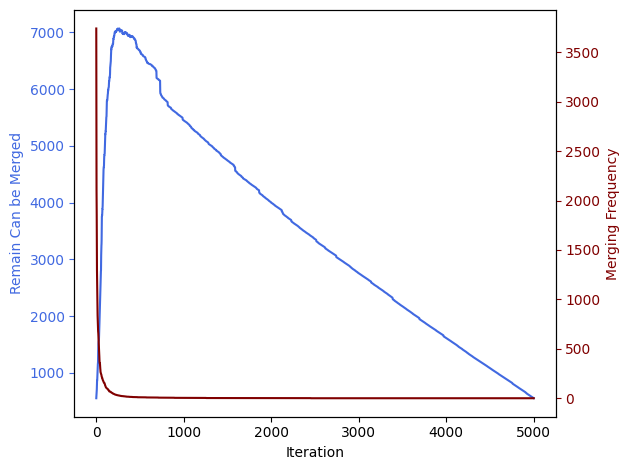

In [40]:
print("Train 5000 iters:")
draw_iters({k: v[:5000] for k, v in results.items()})

因此从上图可以理解训练轮数过多时英文分词结果变差，是因为随着选择合并的字符对频率越来越低，意味着这本身应该作为两个单独的字符存在，而不是具有普适性的合并态。如果强制训练多轮，将所有低频率的、特异性的字符组合也合并，则在最长匹配时就会匹配不到其中一个字符，只能匹配到还剩下的离散字符；等到训练轮数达到5000左右时，离散字符也都和频率极低的字符合并成频率更低的字符，该模型就出现了无法匹配文本 `<unknown>` 的情况。

下面是绘制了 1000 轮训练的结果，更具体观察可合并字符对的变化。可以看到，在 200 轮训练之前，合并行为可以带来更多的收益，并且所选择合并字符对也具有极高的频率，意味着合并是合理的，因此这个阶段的训练是必要的。在200-400轮训练中，虽然合并字符对的频率已经指数降低了很多，但合并行为仍然带来了更多的合并选择，说明此阶段仍然学习到了新知识。在 400 轮训练之后，存在一段平滑期，随后在 700 轮以后，合并字符对的频率维持在较低水平，同时随着合并的进行，也没有更多的合并选择，**此后的训练逐渐开始合并本应独立存在的有意义的字符，**最终导致分词结果重新变得离散化，甚至出现 `<unknown>`.   

Train 1000 iters:


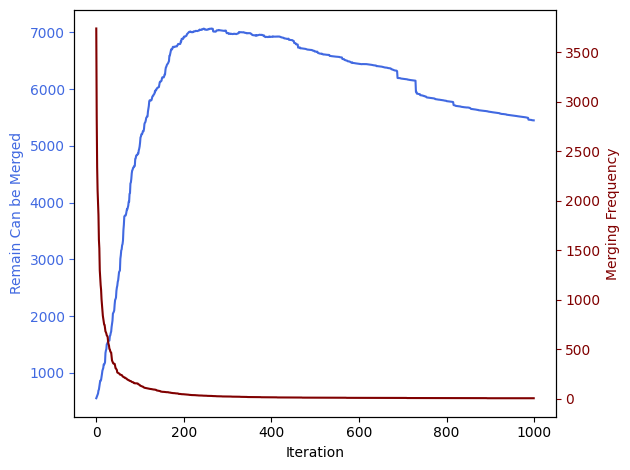

In [41]:
print("Train 1000 iters:")
draw_iters({k: v[:1000] for k, v in results.items()})